In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from scipy import linalg
from tqdm import tqdm

In [ ]:
# !pip uninstall cupy-cuda110 cupy-cuda12x
# !pip install cupy-cuda110
# import cupy as cp

In [ ]:
large_data = False
if large_data:
  !wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
  !unzip ml-25m.zip
  path = "ml-25m/"
else:
  !wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
  !unzip ml-latest-small.zip
  path = "ml-latest-small/"

--2024-05-13 19:48:09--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.04MB/s    in 0.3s    

2024-05-13 19:48:09 (3.04 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


# Datasets

In [ ]:
large_data = False
if large_data:
    path = "ml-25m/"
else:
    path = "ml-latest-small/"


In [ ]:
movies = pd.read_csv(path + "movies.csv")

In [ ]:
print("Number of movies : ",movies.shape[0])
genres = '|'.join(list(movies["genres"])).split("|")
print("Number of genres : ",len(set(genres)))
print(f"Many of the movies have the genre {max(genres)}")

Number of movies :  9742
Number of genres :  20
Many of the movies have the genre Western


In [ ]:
tags = pd.read_csv(path + "tags.csv")

In [ ]:
print("Number of tags : ", tags.shape[0])
u_id, counts = np.unique(tags.userId.values, return_counts=True)
print(f"The higher number of tags is {np.max(counts)} and come from the user {u_id[np.argmax(counts)]}")
print(f"The lower number of tags is {np.min(counts)} and come from the user {u_id[np.argmin(counts)]}")
del u_id, counts
m_id, counts = np.unique(tags.movieId.values, return_counts=True)
print(f"The movie the most tagged is {m_id[np.argmax(counts)]} and has been tagged {max(counts)} times")
print(f"The movie the least tagged is {m_id[np.argmin(counts)]} and has been tagged {min(counts)} times")
del m_id, counts

Number of tags :  3683
The higher number of tags is 1507 and come from the user 474
The lower number of tags is 1 and come from the user 7
The movie the most tagged is 296 and has been tagged 181 times
The movie the least tagged is 7 and has been tagged 1 times


In [ ]:
ratings = pd.read_csv(path + "ratings.csv")
ratings.head(8)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176


In [ ]:
u_id, counts = np.unique(ratings.userId.values, return_counts=True)
print("The number of users rated a movie is ",len(u_id))
print(f"The user rated the most of movies is {u_id[np.argmax(counts)]} and has rated {np.max(counts)}")
print(f"The user ids are numberred from {min(u_id)} to {max(u_id)}")
del u_id, counts

m_id, counts = np.unique(ratings.movieId.values, return_counts=True)
print("The number of movies rated is : ",len(m_id))
print(f"The movie the most rated is {m_id[np.argmax(counts)]} and has been rated {np.max(counts)} times")
del m_id, counts
print(f"The mean of ratings is : {ratings.rating.values.mean()}")
print(f"The small rating is {np.min(ratings.rating.values)}")
print(f"The bigger rating is {np.max(ratings.rating.values)}")

The number of users rated a movie is  610
The user rated the most of movies is 414 and has rated 2698
The user ids are numberred from 1 to 610
The number of movies rated is :  9724
The movie the most rated is 356 and has been rated 329 times
The mean of ratings is : 3.501556983616962
The small rating is 0.5
The bigger rating is 5.0


# Data Indexing

In [ ]:
ratings = ratings.values

In [ ]:
M = len(np.unique(ratings[:,0]))
N = len(np.unique(ratings[:,1]))

In [ ]:
#@title Indexing the whole dataset
movie_to_id = {}#dictionary
id_to_movie = []
user_to_id = {}#dictionary
id_to_user = []
data_by_user = []
data_by_movie = []

for i in range(ratings.shape[0]):
  u_id = ratings[i,0]
  #check if u_id is already in user_to_id
  if not u_id in user_to_id.keys():
    user_to_id[u_id] = len(user_to_id)
    id_to_user.append(u_id)
  #get the movieId watched by user
  m_id =  ratings[i,1]
  #check if movieId (watched by user) is already in movie_to_id
  if not m_id in movie_to_id.keys():
    movie_to_id[m_id] = len(movie_to_id)
    id_to_movie.append(m_id)
  ###########################################
  #add (movieId_new_id, rating) in the dict
  try:
    data_by_user[user_to_id[u_id]].append((movie_to_id[m_id], ratings[i,2]))
  except:
    data_by_user.append([(movie_to_id[m_id], ratings[i,2])])
  ##########################################
  #add (user_new_id, rating) in the dict
  try:
    data_by_movie[movie_to_id[m_id]].append((user_to_id[u_id], ratings[i,2]))
  except:
    data_by_movie.append([(user_to_id[u_id], ratings[i,2])])


M = len(user_to_id)
N = len(movie_to_id)

#Number of ratings per users for the training set
number_of_ratings_per_users = [int(0.8*len(l)) for l in data_by_user]

In [ ]:
# number_of_ratings_per_users = [int(0.8*len(np.where(ratings[:,0] == id)[0])) for id in np.sort(np.unique(ratings[:,0]))]

In [ ]:
#@title Data indexing v1
# import numpy as np

movie_to_id = {}
id_to_movie = []
user_to_id = {}
id_to_user = []
train_data_by_user = [[] for _ in range(M)]
train_data_by_movie = [[] for _ in range(N)]
#
test_data_by_user = [[] for _ in range(M)]
test_data_by_movie = [[] for _ in range(N)]

num_of_users_in_the_train_set = 0
for i in range(ratings.shape[0]):
    u_id = ratings[i, 0]
    if u_id not in user_to_id:
      num_of_users_in_the_train_set += 1
      user_to_id[u_id] = len(user_to_id)
      id_to_user.append(u_id)

    m_id = ratings[i, 1]
    if m_id not in movie_to_id:
      movie_to_id[m_id] = len(movie_to_id)
      id_to_movie.append(m_id)

    rating = ratings[i, 2]
    user_index = user_to_id[u_id]
    movie_index = movie_to_id[m_id]

    if num_of_users_in_the_train_set < int(M * 0.8):
      train_data_by_user[user_index].append((movie_index, rating))
      train_data_by_movie[movie_index].append((user_index, rating))
    else:
      test_data_by_user[user_index].append((movie_index, rating))
      test_data_by_movie[movie_index].append((user_index, rating))

    # data_by_movie[movie_index].append((user_index, rating))

In [ ]:
print(len(train_data_by_user[0][0]))
print(len(train_data_by_user[0][1]))

2
2


In [ ]:
A = np.array([[1, 2], [3,-1]])
print(np.sum(A**2))

15


In [ ]:
print(num_of_users_in_the_train_set)

610


In [ ]:
# print(len(train_data_by_user))
# print(len(test_data_by_user))

In [ ]:
# i = 0
# boolean = True
# while (i< num_of_users_in_the_train_set) and boolean:
#   i += 1
#   boolean = len(train_data_by_user[i]) + len(test_data_by_user[i]) == len(np.where(ratings[:,0] == id_to_user[i])[0])

# print(boolean)

# Training the model

In [ ]:
#@title v1

#hyperparameters
K  = 10
lambd = 1
gamma = 1e-4
tau = 0.8
num_epoch = 10

#Initialization
user_vec = np.random.randn(M, K)/np.sqrt(K)
user_biases = np.zeros(M)
item_vec = np.random.randn(K, N)/np.sqrt(K)
item_biases = np.zeros(N)
##
train_losses = []
test_losses = []
list_rmse_train = []
list_rmse_test = []

##
for epoch in tqdm(range(num_epoch)):
  for m in range(M):
    #update user_vec[m,:] and update item_biases[:,n]
    first_term = np.zeros((K,K))
    second_term = np.zeros(K)
    bias = 0
    item_counter = 0
    for (n,r) in train_data_by_user[m]:
      first_term += np.transpose(item_vec[:,n]).dot(item_vec[:,n])
      second_term += item_vec[:,n]*(r - user_biases[m] - item_biases[n])
      bias += lambd * (r-(user_vec[m,:].dot(item_vec[:,n].T)+item_biases[n]))
      item_counter += 1
    bias = bias/(lambd*item_counter + gamma)
    user_biases[m] = bias
    first_term = lambd*first_term + tau* np.eye(K,K)
    second_term = np.transpose(second_term*lambd)
    user_vec[m,:] = linalg.solve(first_term, second_term)
  #
  for n in range(N):
    #update item_vec[:,n]
    first_term = np.zeros((K,K))
    second_term = np.zeros(K)
    bias = 0
    user_counter = 0
    for (m,r) in train_data_by_movie[n]:
      first_term += np.transpose(user_vec[m,]).dot(user_vec[m,:])
      second_term += user_vec[m,:]*(r - user_biases[m] - item_biases[n])
      bias += lambd * (r-(user_vec[m,:].dot(item_vec[:,n].T)+user_biases[m]))
      user_counter += 1
    bias = bias/(lambd*user_counter + gamma)
    item_biases[n] = bias
    first_term = lambd*first_term + tau* np.eye(K,K)
    second_term = np.transpose(second_term*lambd)
    item_vec[:,n] = linalg.solve(first_term, second_term)
    #update item_biases
  #Loss and rmse
  loss_train = 0.0
  item_counter = 0
  som = 0
  for m in range(len(train_data_by_user)):
    for (n,r) in train_data_by_user[m]:
      item_counter += 1
      som += (r-(user_vec[m,:].dot(item_vec[:,n].T) + user_biases[m] + item_biases[n]))**2
  loss_train += 0.5*lambd*som + 0.5*tau*(np.sum(user_vec**2)+np.sum(item_vec**2))+0.5*gamma*(np.sum(user_biases**2)+np.sum(item_biases**2))
  rmse = np.sqrt(som/item_counter)
  train_losses.append(loss_train.copy())
  list_rmse_train.append(rmse.copy())

In [ ]:
np.transpose(item_vec[:,n]).dot(item_vec[:,n])

8.450516920597347e+24

In [ ]:
# loss = 0
# for m in range(M):
#   for (n,r) in train_data_by_user:

# som1 = np.sum(user_vec**2)#sum([user_vec[m,:].matmul(user_vec[m,:].T) for m in range(M)])
# som2 = np.sum(item_vec**2)#sum([item_vec[:,n].matmul(item_vec[:,n].T) for n in range(N)])
# som3 = np.sum(user_biases**2)+np.sum(item_biases**2)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(list(range(num_epoch)), train_losses, label="Training")
# ax[0].plot(list(range(num_epoch)), losses_test, label="Test")
ax[0].set_title("Training Loss")
ax[0].legend()
ax[1].plot(list(range(num_epoch)), list_rmse_train, label="Training")
# ax[1].plot(list(range(num_epoch)), list_rmse_test, label="Test")
ax[1].legend()
ax[1].set_title("RMSE")
plt.show()

In [ ]:
#@title Data indexing v2

np.random.shuffle(ratings)

movie_to_id = {}
id_to_movie = []
user_to_id = {}
id_to_user = []
train_data_by_user = [[[], []] for _ in range(M)]
train_data_by_movie = [[[], []] for _ in range(N)]
#
test_data_by_user = [[[], []] for _ in range(M)]
test_data_by_movie = [[[], []] for _ in range(N)]

num_of_users_in_the_train_set = 0
for i in tqdm(range(ratings.shape[0])):
    u_id = ratings[i, 0]
    if u_id not in user_to_id:
      num_of_users_in_the_train_set += 1
      user_to_id[u_id] = len(user_to_id)
      id_to_user.append(u_id)

    m_id = ratings[i, 1]
    if m_id not in movie_to_id:
      movie_to_id[m_id] = len(movie_to_id)
      id_to_movie.append(m_id)

    rating = ratings[i, 2]
    user_index = user_to_id[u_id]
    movie_index = movie_to_id[m_id]

    if num_of_users_in_the_train_set < int(M * 0.8):
      train_data_by_user[user_index][0].append(movie_index)
      train_data_by_user[user_index][1].append(rating)
      train_data_by_movie[movie_index][0].append(user_index)
      train_data_by_movie[movie_index][1].append(rating)
    else:
      test_data_by_user[user_index][0].append(movie_index)
      test_data_by_user[user_index][1].append(rating)
      test_data_by_movie[movie_index][0].append(user_index)
      test_data_by_movie[movie_index][1].append(rating)

100%|██████████| 100836/100836 [00:00<00:00, 179555.48it/s]


In [ ]:
#@title Data indexing v2.1

# np.random.shuffle(ratings)
#Get number of ratings per user

# movie_to_id = {}
# id_to_movie = []
# user_to_id = {}
# id_to_user = []
train_data_by_user = [[[], []] for _ in range(M)]
train_data_by_movie = [[[], []] for _ in range(N)]
#
test_data_by_user = [[[], []] for _ in range(M)]
test_data_by_movie = [[[], []] for _ in range(N)]


#
for i in tqdm(range(ratings.shape[0])):
    u_id = ratings[i, 0]
    if u_id not in user_to_id:
      user_to_id[u_id] = len(user_to_id)
      id_to_user.append(u_id)

    m_id = ratings[i, 1]
    if m_id not in movie_to_id:
      movie_to_id[m_id] = len(movie_to_id)
      id_to_movie.append(m_id)

    rating = ratings[i, 2]
    user_index = user_to_id[u_id]
    movie_index = movie_to_id[m_id]

    if len(train_data_by_user[user_to_id[u_id]][0]) < number_of_ratings_per_users[user_to_id[u_id]]:
      train_data_by_user[user_index][0].append(movie_index)
      train_data_by_user[user_index][1].append(rating)
      train_data_by_movie[movie_index][0].append(user_index)
      train_data_by_movie[movie_index][1].append(rating)
    else:
      test_data_by_user[user_index][0].append(movie_index)
      test_data_by_user[user_index][1].append(rating)
      test_data_by_movie[movie_index][0].append(user_index)
      test_data_by_movie[movie_index][1].append(rating)

100%|██████████| 100836/100836 [00:01<00:00, 66590.87it/s]


In [ ]:
print(len(train_data_by_user[0][1]))
print(len(test_data_by_user[0][1]))

In [ ]:
#@title Training v2

#hyperparameters
K  = 50
lambd = 1e-5
gamma = 0.01
tau = 0.1
num_epoch = 20

#Initialization
user_vec = np.random.normal(0, 1/np.sqrt(K), size= (M, K))
user_biases = np.zeros((1,M))
item_vec = np.random.normal(0, 1/np.sqrt(K), size=(K, N))
item_biases = np.zeros((1,N))
##

##
train_losses = []
test_losses = []
list_rmse_train = []
list_rmse_test = []

##
for epoch in tqdm(range(num_epoch)):
  for m in range(M):
    # and
    movie_indices = train_data_by_user[m][0]
    r_m = np.array([train_data_by_user[m][1]])
    #update item_biases[:,n]
    user_biases[0,m] = lambd*np.sum(r_m - (user_vec[m,:].T).dot(item_vec[:,movie_indices]) - item_biases[0,movie_indices])/(lambd*len(r_m)+gamma)

  for m in range(M):
    # and
    movie_indices = train_data_by_user[m][0]
    r_m = np.array([train_data_by_user[m][1]])
    #update user_vec[m,:]
    first_term = lambd*item_vec[:,movie_indices].dot(item_vec[:,movie_indices].T) + tau*np.eye(K,K)
    second_term = lambd * np.sum((r_m - user_biases[0,m] -item_biases[0,movie_indices]) * item_vec[:,movie_indices], axis=1).T
    user_vec[m,:] = linalg.solve(first_term, second_term)

  #
  for n in range(N):
    #
    user_indices = train_data_by_movie[n][0]
    r_n = np.array([train_data_by_movie[n][1]])
    #update user_vec[m,:]
    first_term = lambd*np.dot(user_vec[user_indices,:].T, user_vec[user_indices,:]) + tau*np.eye(K,K)
    #print(first_term.shape)
    # break
    ################
    second_term = lambd * np.sum((r_n - item_biases[0,n] -user_biases[0,user_indices]) * user_vec[user_indices,:].T, axis=1)
    ################
    item_vec[:,n] = linalg.solve(first_term, second_term)
    #update item_biases[:,n]
    item_biases[0,n] = lambd*np.sum(r_n - np.dot(user_vec[user_indices,:], item_vec[:,n]) - user_biases[0,user_indices])/(lambd*len(r_n)+gamma)
  #Loss and rmse
  loss_train = 0.0
  som = 0
  # count = 0
  for m in range(len(train_data_by_user)):#np.dot(user_vec[user_indices,:], item_vec[:,n])
    movie_indices = train_data_by_user[m][0]
    r_m = np.array([train_data_by_user[m][1]])
    som += np.sum((r_m - (user_vec[m,:].T).dot(item_vec[:,movie_indices]) - user_biases[0,m] - item_biases[0,movie_indices])**2)
    # count += 1
  loss_train += 0.5*lambd*som + 0.5*tau*(np.sum(user_vec**2)+np.sum(item_vec**2))+0.5*gamma*(np.sum(user_biases**2)+np.sum(item_biases**2))
  rmse = np.sqrt(som/len(train_data_by_user))
  train_losses.append(loss_train.copy())
  list_rmse_train.append(rmse.copy())

In [ ]:
# fig, ax = plt.subplots(1,2, figsize=(10,4))
# ax[0].plot(list(range(num_epoch)), train_losses, label="Training")
# # ax[0].plot(list(range(num_epoch)), losses_test, label="Test")
# ax[0].set_title("Training Loss")
# ax[0].legend()
# ax[1].plot(list(range(num_epoch)), list_rmse_train, label="Training")
# # ax[1].plot(list(range(num_epoch)), list_rmse_test, label="Test")
# ax[1].legend()
# ax[1].set_title("RMSE")
# plt.show()

In [ ]:
def loss_func(train_data_by_user, user_vec, item_vec, user_biases, item_biases, tau, gamma, lambd):
  residual = 0
  count = 0
  for m in range(len(train_data_by_user)):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    count += len(movie_indices)
    residual += np.sum((r_m - (np.dot(user_vec[m].T, item_vec[movie_indices].T)+user_biases[m]+item_biases[movie_indices]))**2)
  loss = 0.5*lambd*residual+ 0.5*tau*(np.sum(user_vec**2)+np.sum(item_vec**2))+ 0.5*gamma*(np.sum(user_biases**2)+np.sum(item_biases**2))
  rmse = np.sqrt(residual/count)
  return loss, rmse

In [ ]:
#@title Training v2.1

#hyperparameters
K  = 10#60
lambd = 0.1#5
gamma = 0.1#0.2
tau = 0.1#0.2
num_epoch = 10#40

#Initialization
# user_vec = np.random.normal(0, 1/np.sqrt(K), size= (M, K))
user_vec = np.zeros((M, K))
user_biases = np.zeros(M)
# item_vec = np.random.normal(0, 1/np.sqrt(K), size=(N,K))
item_vec = np.zeros((N,K))

item_biases = np.zeros(N)
##

##
train_loss_history = []
test_loss_history = []
train_rmse_history = []
test_rmse_history = []

##
for epoch in tqdm(range(num_epoch)):
  #user biases
  for m in range(M):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    numerator = np.sum(r_m - np.dot(user_vec[m].T, item_vec[movie_indices,:].T)-item_biases[movie_indices])
    user_biases[m] = lambd*numerator/(lambd*len(movie_indices)+gamma)
    # #user_vec
    # for m in range(M):
    #   movie_indices = train_data_by_user[m][0]
    #   r_m = np.array(train_data_by_user[m][1])
    # term1 = lambd*np.dot(item_vec[movie_indices].T, item_vec[movie_indices])+tau*np.eye(K,K)
    # term2 = r_m - user_biases[m] - item_biases[movie_indices]
    # term2 = lambd*np.sum(item_vec[movie_indices]*term2.reshape(-1,1), axis=0)
    # user_vec[m] = linalg.solve(term1, term2)
  #item biases
  for n in range(N):
    user_indices = train_data_by_movie[n][0]
    r_n = np.array(train_data_by_movie[n][1])
    numerator = np.sum(r_n -np.dot(user_vec[user_indices,:], item_vec[n].T) -user_biases[user_indices])
    item_biases[n] = lambd*numerator/(lambd*len(user_indices)+gamma)
    # for n in range(N):
    #   user_indices = train_data_by_movie[n][0]
    #   r_n = np.array(train_data_by_movie[n][1])
    # term1 = lambd*np.dot(user_vec[user_indices].T, user_vec[user_indices])+tau*np.eye(K,K)
    # term2 = r_n - user_biases[user_indices] - item_biases[n]
    # term2 = lambd*np.sum(user_vec[user_indices]*term2.reshape(-1,1), axis=0)
    # item_vec[n] = linalg.solve(term1, term2)
  #Loss
  loss, rmse = loss_func(train_data_by_user, user_vec, item_vec, user_biases, item_biases, tau, gamma, lambd)
  train_loss_history.append(loss.copy())
  train_rmse_history.append(rmse.copy())
  test_loss, test_rmse = loss_func(test_data_by_user, user_vec, item_vec, user_biases, item_biases, tau, gamma, lambd)
  test_loss_history.append(test_loss.copy())
  test_rmse_history.append(test_rmse.copy())

100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


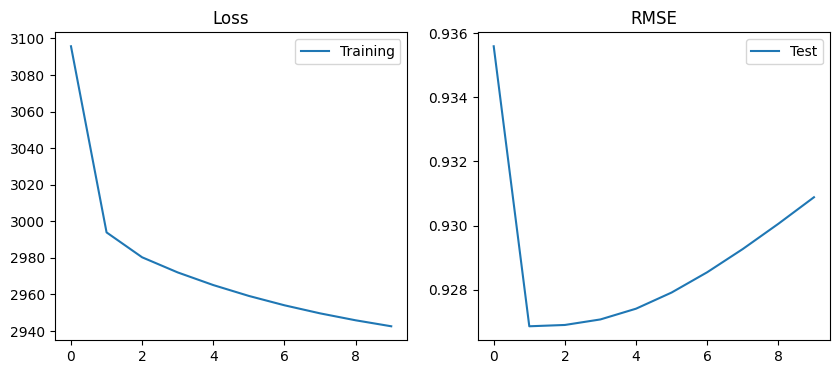

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(list(range(num_epoch)), train_loss_history, label="Training")
# ax[0].plot(list(range(num_epoch)), test_loss_history, label="Test")
ax[0].set_title("Loss")
# ax[0].set_xlim(-2,num_epoch)
ax[0].legend()#test_loss_history
# ax[1].plot(list(range(num_epoch)), train_rmse_history, label="Training")
ax[1].plot(list(range(num_epoch)), test_rmse_history, label="Test")
ax[1].legend()
ax[1].set_title("RMSE")
plt.show()

In [ ]:
for m in [1,15, 100, 123, 150,194,201]:
  print(f"User {id_to_user[m]} :")
  n = test_data_by_user[m][0][5]
  print("\tTrue rate : ",test_data_by_user[m][1][5])
  print("\tPredicted rate : ", np.dot(user_vec[m].T, item_vec[n].T)+user_biases[m]+item_biases[n])

User 2.0 :
	True rate :  5.0
	Predicted rate :  4.057618146893659
User 16.0 :
	True rate :  3.5
	Predicted rate :  2.8690540060336907
User 101.0 :
	True rate :  1.0
	Predicted rate :  1.583045721403608
User 124.0 :
	True rate :  5.0
	Predicted rate :  4.269793920959615
User 151.0 :
	True rate :  3.0
	Predicted rate :  5.554407666013455
User 195.0 :
	True rate :  5.0
	Predicted rate :  5.561038497940208
User 202.0 :
	True rate :  5.0
	Predicted rate :  3.8387640362773867


In [ ]:
#@title Save my model
%mkdir model_amls
# %mkdir model_amls/datasets
import pickle

with open("model_amls/user_vec.txt", "wb") as f:
  pickle.dump(user_vec, f)
  print("user_vec saved...")

with open("model_amls/item_vec.txt", "wb") as f:
  pickle.dump(item_vec, f)
  print("item_vec saved...")

with open("model_amls/user_biases.txt", "wb") as f:
  pickle.dump(user_biases, f)
  print("user_biases saved...")

with open("model_amls/item_biases.txt", "wb") as f:
  pickle.dump(item_biases, f)
  print("item_biases saved...")

with open("model_amls/train_loss_history.txt", "wb") as f:
  pickle.dump(train_loss_history, f)
  print("train_loss_history saved...")

with open("model_amls/test_loss_history.txt", "wb") as f:
  pickle.dump(test_loss_history, f)
  print("test_loss_history saved...")

with open("model_amls/train_rmse_history.txt", "wb") as f:
  pickle.dump(train_rmse_history, f)
  print("train_rmse_history saved...")

with open("model_amls/test_rmse_history.txt", "wb") as f:
  pickle.dump(test_rmse_history, f)
  print("test_rmse_history saved...")

print("done...")

user_vec saved...
item_vec saved...
user_biases saved...
item_biases saved...
train_loss_history saved...
test_loss_history saved...
train_rmse_history saved...
test_rmse_history saved...
done...


In [ ]:
!unzip /content/model_amls.zip

Archive:  /content/model_amls.zip
   creating: model_amls/
   creating: model_amls/datasets/
  inflating: model_amls/test_loss_history.txt  
  inflating: model_amls/train_loss_history.txt  
  inflating: model_amls/train_rmse_history.txt  
  inflating: model_amls/test_rmse_history.txt  
  inflating: model_amls/item_biases.txt  
  inflating: model_amls/user_biases.txt  
  inflating: model_amls/user_vec.txt  
  inflating: model_amls/item_vec.txt  


In [ ]:
#@title Load model

import pickle

with open("/content/model_amls/user_vec.txt", "rb") as f:
  user_vec = pickle.load(f)

with open("/content/model_amls/item_vec.txt", "rb") as f:
  item_vec = pickle.load(f)

with open("/content/model_amls/user_biases.txt", "rb") as f:
  user_biases = pickle.load(f)

with open("/content/model_amls/item_biases.txt", "rb") as f:
  item_biases = pickle.load(f)

print("done...")

# Prediction

In [ ]:
#user training
new_user = np.zeros(K)
r_m = np.array([5])
movie_indices = [5]
for epoch in range(num_epoch):
    #     numerator = np.sum(r_m - np.dot(new_user, item_vec[movie_indices,:].T)-item_biases[movie_indices])
    #     user_biases[m] = lambd*numerator/(lambd*len(r_m)+gamma)
    term1 = lambd*np.dot(item_vec[movie_indices].T, item_vec[movie_indices])+tau*np.eye(K,K)
    term2 = r_m - user_biases[m] - item_biases[movie_indices]
    term2 = lambd*np.sum(item_vec[movie_indices]*term2.reshape(-1,1), axis=0)
    new_user = linalg.solve(term1, term2)

In [ ]:
score_for_item = [np.dot(new_user, item_vec[n])+item_biases for n in range(N)]

In [ ]:
print(argmax(score_for_item))